BioIB application in scRNA-seq dataset of HuMEC cells in the context of epithelial-to-mesenchymal transition (EMT)

Data from https://www.nature.com/articles/s41588-019-0489-5;
Preprossesing as in https://www.nature.com/articles/s43588-024-00721-5



In [ ]:
from bioib import bioib, utils, plotting

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings("ignore")

Data with 17632 cells and 5000 highly variable genes


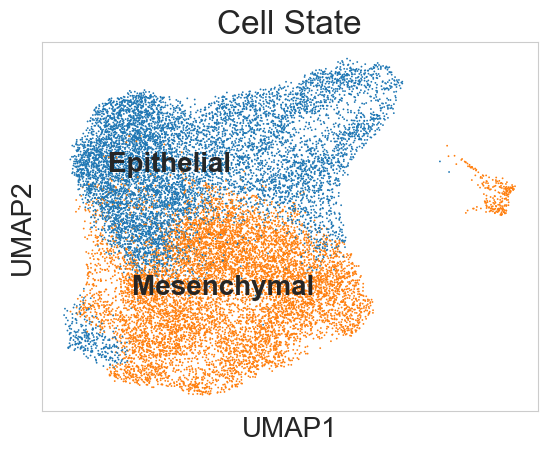

In [3]:
adata = sc.read_h5ad('EMT/adata_EMT_preprocessed_humec.h5ad')
print('Data with %s cells and %s highly variable genes' % adata.shape)
with plt.rc_context():
    sc.pl.umap(adata, color='CellType', legend_loc='on data',
           show=False,)
    plt.title('Cell State')
    plt.show()

In [9]:
signal_of_interest='CellType'
groups_of_interest=['Epithelial', 'Mesenchymal']
n_metagenes=3
bioib_sort = bioib.bioIB(
    adata=adata,
    signal_of_interest=signal_of_interest,
    groups_of_interest=groups_of_interest,
    bulk=True,
    copy=True)
adata = bioib_sort.flat_clustering(n_metagenes)

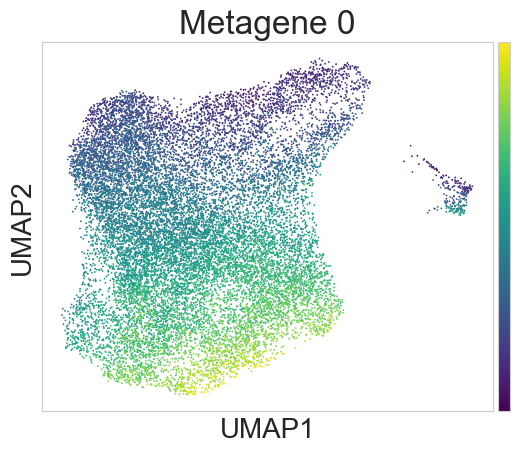

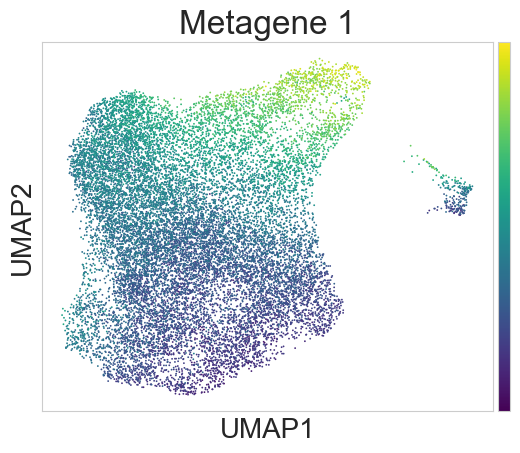

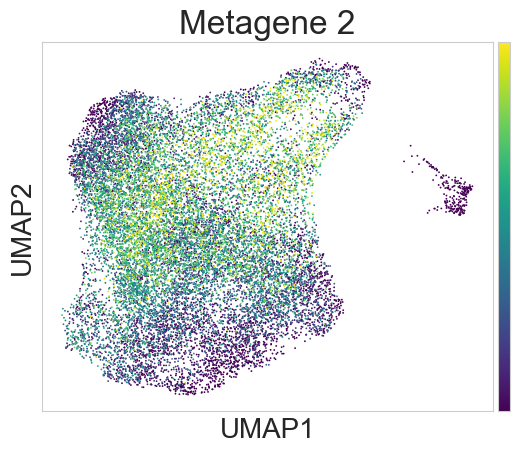

In [12]:
for mg in range(n_metagenes):
    with plt.rc_context():
        if mg==2: #Put here the index of the transitioning metagene
            sc.pl.umap(adata, color=['Metagene %s' % mg], cmap='viridis',
               ncols=1, vmin=1.75,vmax=1.9,show=False)
        else:
            sc.pl.umap(adata, color=['Metagene %s' % mg],cmap='viridis',
               ncols=1, show=False)
        fig = plt.gcf()
        axes = fig.axes
        colorbar = axes[-1]  # Scanpy appends it last
        # Remove ticks
        colorbar.tick_params(left=False, right=False, labelleft=False,
                             bottom=False, top=False, labelbottom=False)
        colorbar.set_xticks([])
        colorbar.set_yticks([])
        plt.show()

MG 0 - Epithelial markers: 
SignificanceResult(statistic=-0.4649076165203328, pvalue=0.0)
MG 0 - Mesenchymal markers: 
SignificanceResult(statistic=0.7324904503250838, pvalue=0.0)
MG 1 - Epithelial markers: 
SignificanceResult(statistic=0.5706506986799278, pvalue=0.0)
MG 1 - Mesenchymal markers: 
SignificanceResult(statistic=-0.6523497977297735, pvalue=0.0)
MG 2 - Epithelial markers: 
SignificanceResult(statistic=0.22157568528087646, pvalue=5.110483187216169e-195)
MG 2 - Mesenchymal markers: 
SignificanceResult(statistic=-0.13414353858439035, pvalue=1.3619261806472307e-71)


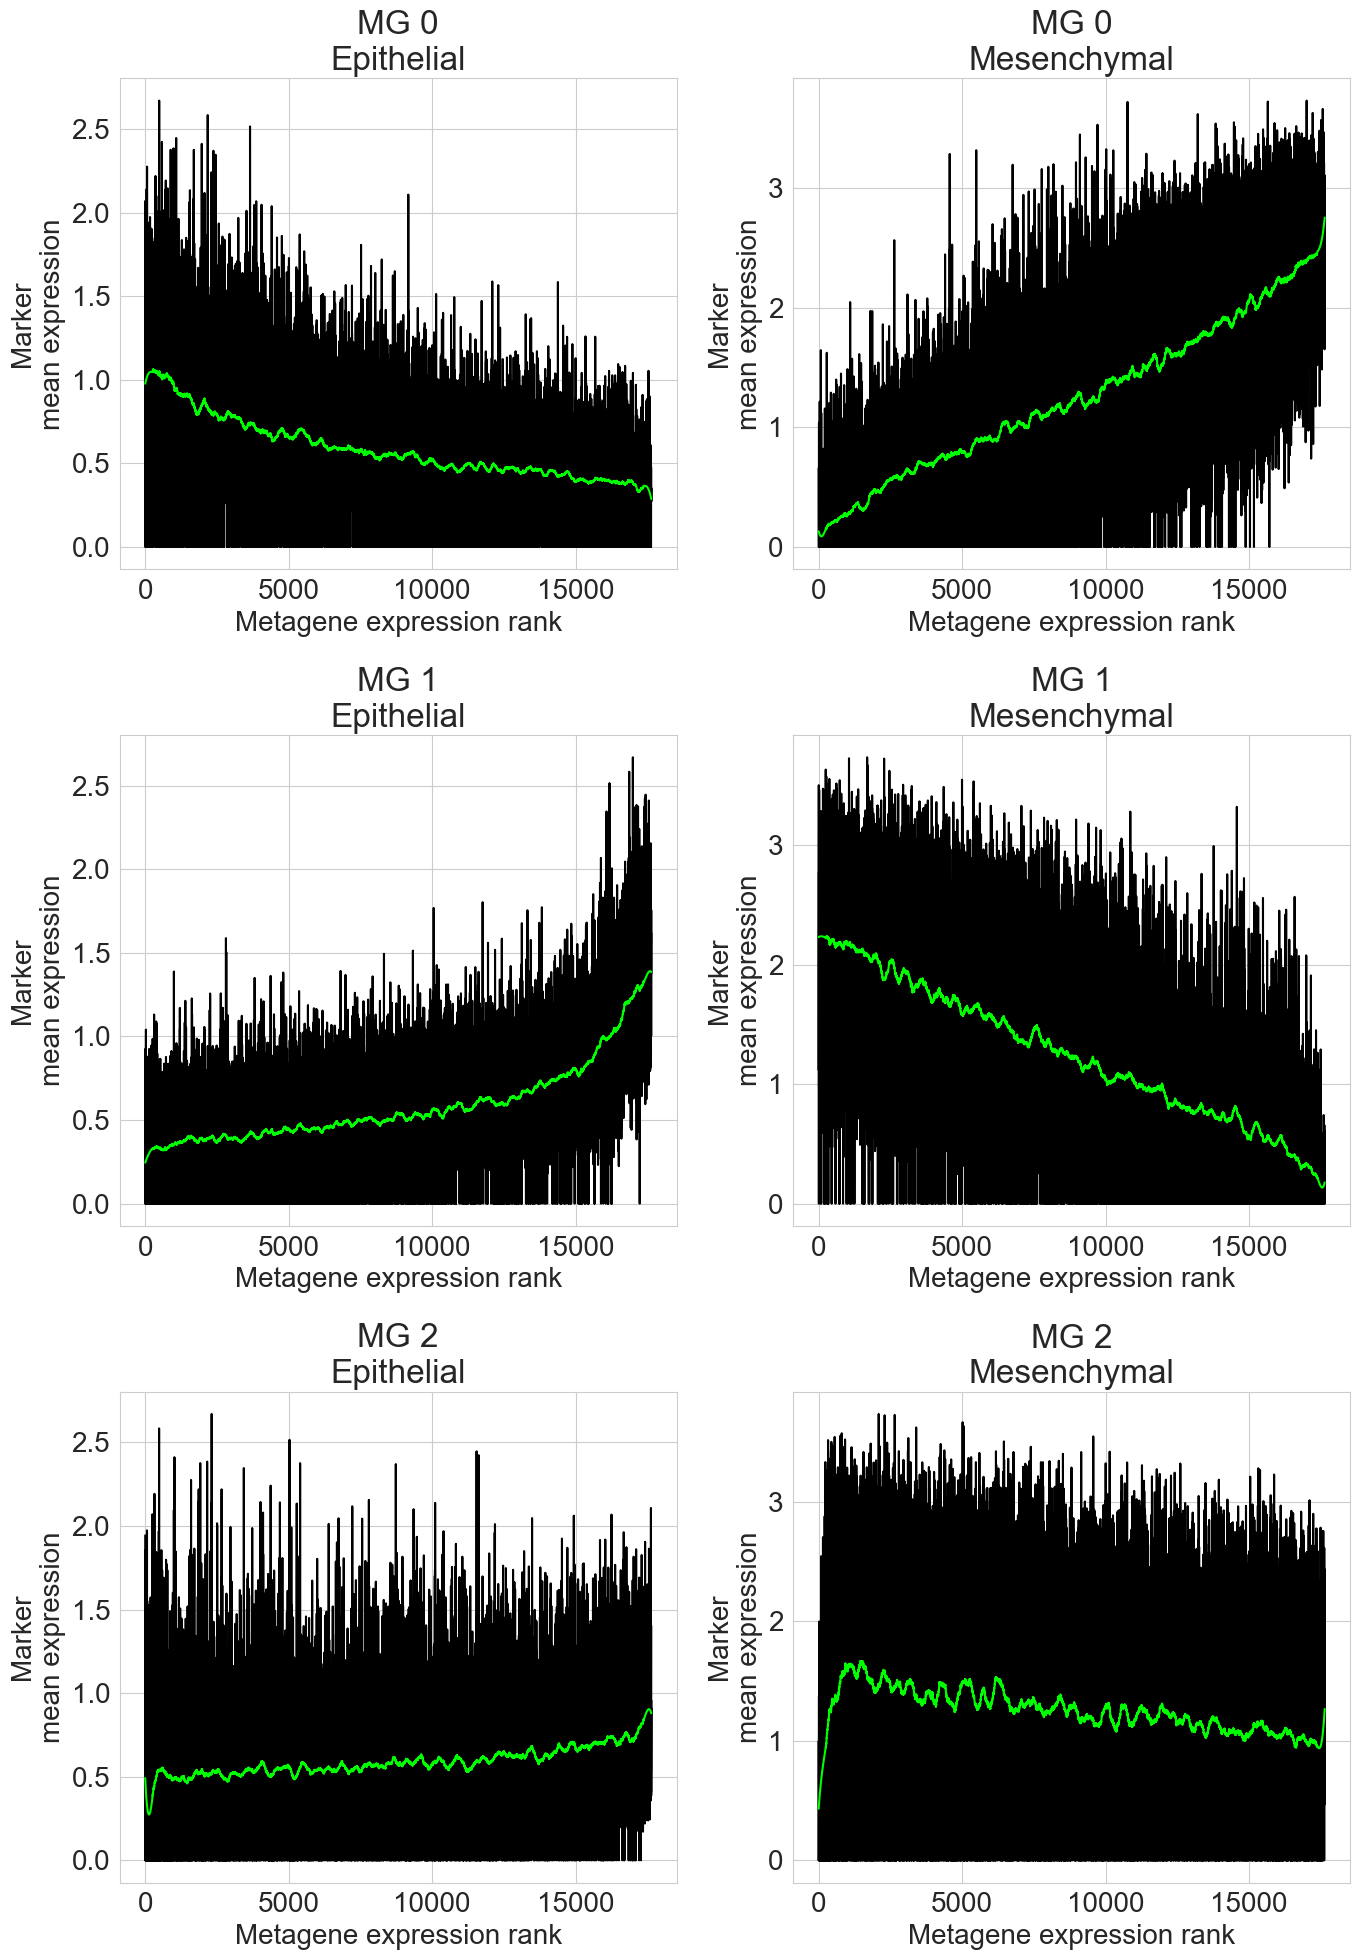

In [13]:
marker_genes_dict = {
    'Epithelial': ['CDH1', 'CRB3','DSP'],
    'Mesenchymal': ['FN1','VIM']
}
from scipy.signal import savgol_filter
import scipy.stats as stats

fig, axs = plt.subplots(3, 2, figsize=(14, 20))
axs=axs.ravel()
a=0

for mg in range(n_metagenes):
    for ct in marker_genes_dict.keys():
        arr_all=adata[:,marker_genes_dict[ct]].X.todense().T
        mean_expr=np.array(np.mean(arr_all,axis=0))[0]
        mg_expr=np.array(adata.obs['Metagene %s' % mg])
        rank=np.argsort(mg_expr)
        print('MG %s - %s markers: ' % (mg, ct))
        print(stats.spearmanr(mg_expr, mean_expr))
        axs[a].plot(range(len(rank)),mean_expr[rank], color='black')
        axs[a].plot(range(len(rank)), savgol_filter(mean_expr[rank],
                                                500,3), color='lime')
        axs[a].set_title('MG %s\n%s' % (mg, ct))
        axs[a].set_xlabel('Metagene expression rank')
        axs[a].set_ylabel('Marker\nmean expression')

        a += 1
plt.tight_layout()
plt.show()

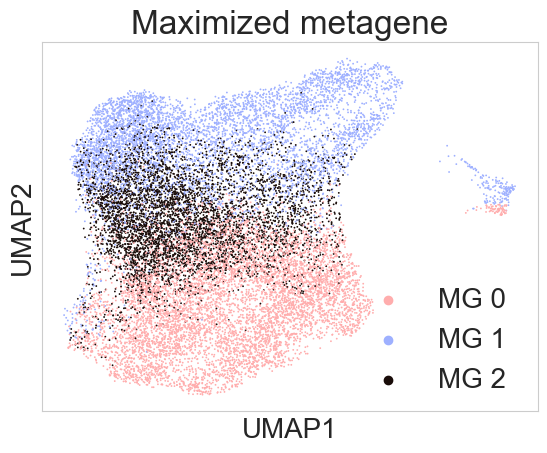

In [14]:
from scipy.stats import zscore
compressed_data = adata.obsm['bioIB_compressed_data_flat_%s_MGs' % n_metagenes]
norm_compressed_data = compressed_data / np.sum(compressed_data, axis=0)
norm_compressed_data = zscore(compressed_data, axis=0)
maximized_mtg = np.argmax(norm_compressed_data, axis=1)
adata.obs['Maximized metagene'] = ['MG %s' % mg for mg in maximized_mtg]

# Get the Berlin colormap
cmap = plt.get_cmap('berlin')
colors = [cmap(i) for i in [1.0, 0.0, 0.5]]
adata.uns['Maximized metagene_colors'] = colors

with plt.rc_context():
    sc.pl.umap(adata, color='Maximized metagene',
               show=False)
    plt.legend(loc=(0.62, 0.02), frameon=False)
    plt.show()

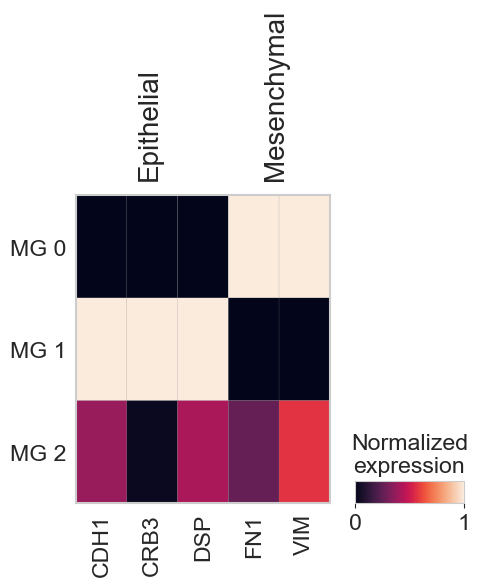

In [15]:
marker_genes_dict = {
    'Epithelial': ['CDH1', 'CRB3','DSP'],
    'Mesenchymal': ['FN1','VIM']
}
with plt.rc_context():
    sc.pl.matrixplot(adata, groupby='Maximized metagene',
                     categories_order=['MG 0', 'MG 1', 'MG 2'],
                     var_names=marker_genes_dict,
                     standard_scale='var',
                     var_group_rotation=90,
                     colorbar_title='Normalized\nexpression',
                     figsize=(5,4),
                     show=False,)
    plt.show()

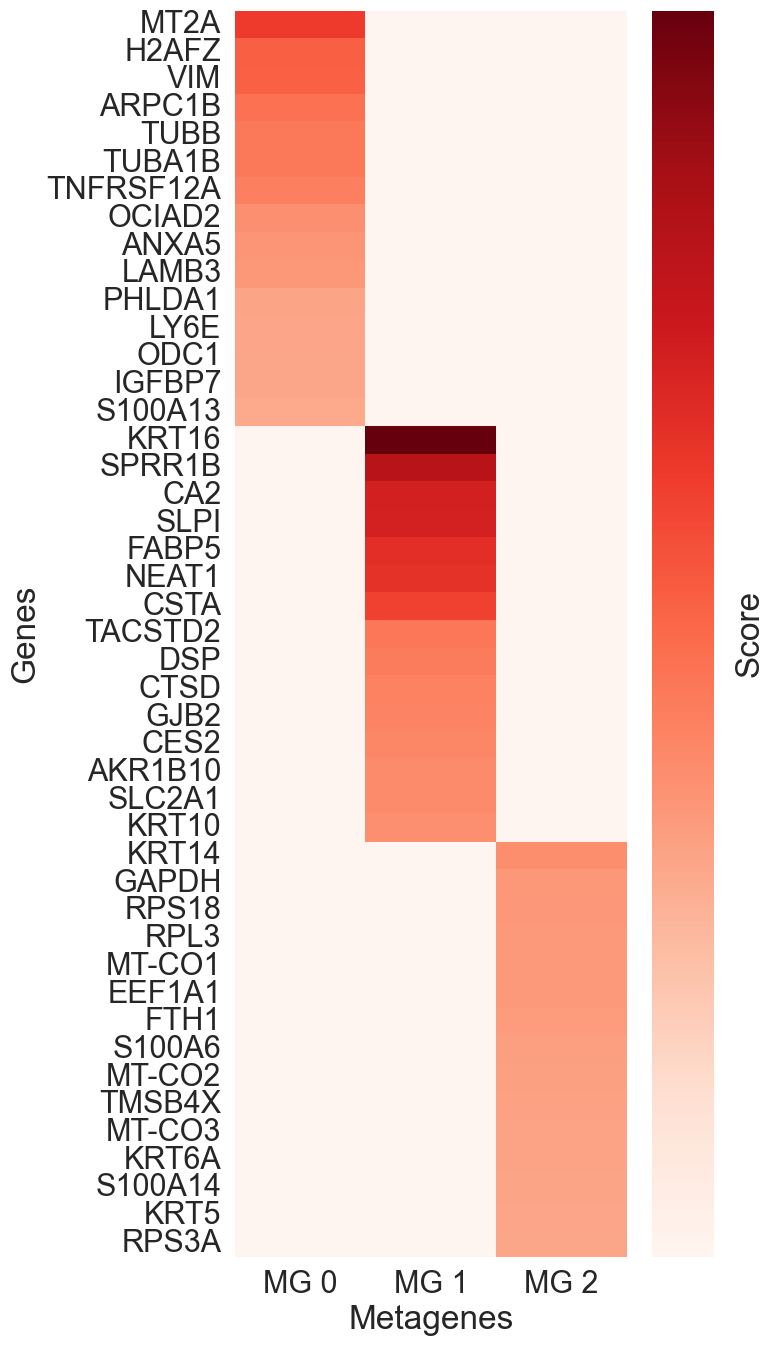

In [19]:
gene_to_metagene = adata.uns["bioIB_flat_%s_MGs_gene_to_MG" % n_metagenes]

n_top_genes=15
chosen_indeces = []
for mtg in range(n_metagenes):
    representative_genes_arr = np.argsort(gene_to_metagene[:, mtg])[::-1][:n_top_genes]
    for g in representative_genes_arr:
        if g not in chosen_indeces:
            chosen_indeces.append(g)
gene_labels = np.array(adata.var_names)[chosen_indeces]

plt.figure(figsize=(8,14))
sns.set_context("notebook", font_scale=2)
ax=sns.heatmap(gene_to_metagene[chosen_indeces, :],
                  xticklabels=['MG %s' % i for i in range(n_metagenes)],
                  yticklabels=gene_labels,
                  cmap='Reds',
          )
# Remove colorbar ticks
cbar = ax.collections[0].colorbar
cbar.set_ticks([])  # removes ticks
cbar.set_label('Score', labelpad=15)

plt.xlabel('Metagenes')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()